In [2]:
import fitsio,os,sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pylab as py


### flagging quasars in DR16Q catalog without rasing any VI issues 
#### See Table 2 here: https://arxiv.org/pdf/2007.09001.pdf

## 0  -->  Not Inspected
## 1  -->  Star
## 3  -->  Quasar 
## 4  -->  Galaxy
## 30  -->  BAL Quasar 
## 50  -->  Blazar(?)   -->  four spectra we identified with high
####                     flux, continua matching an archetypal quasar continuum
####                    shape, and no identifiable absorption or emission features. 




#### Number of quasars in dr16 289926   ((d['CLASS_PERSON']==3) | (d['CLASS_PERSON']==30) & (d['ZWARN_PCA'] ==0) )
#### Number of quasars in dr16 289926   ((d['CLASS_PERSON']==3) | (d['CLASS_PERSON']==30) & (d['ZWARN_PCA'] ==0) )




In [30]:
dh

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2290 / length of dimension 1                          
NAXIS2  =               750414 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  183 / number of table fields                         
TTYPE1  = 'SDSS_NAME'                                                           
TFORM1  = '18A     '                                                            
TTYPE2  = 'RA      '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'DEC     '        

In [12]:
### selecting quasars in DR16Q catalog 
#dr16cat='/uufs/chpc.utah.edu/common/home/sdss/dr16/eboss/spectro/redux/v5_13_0/spAll-v5_13_0.fits'
##dr16cat = '/uufs/chpc.utah.edu/common/home/astro/dawson/sarahE/eboss/July2020/XDQSO/ebosstarget-v0005-qso.fits'

### Oct 2020
dr16cat='/uufs/chpc.utah.edu/common/home/sdss07/dr16/eboss/qso/DR16Q/DR16Q_v4.fits'

dr16 = fits.open(dr16cat)
dh = dr16[1].header
d = dr16[1].data

#np.unique(d['OBJTYPE']) #chararray(['GALAXY', 'NA', 'QSO', 'SKY', 'SPECTROPHOTO_STD'], dtype='<U16')
#qso = (d['CLASS']=='QSO') & (d['ZWARNING'] == 0) #CLASS only exists if using spAll-v5_13_0.fits file, 

### Oct 2020
qso = ((d['CLASS_PERSON']==3) | (d['CLASS_PERSON']==0)  | (d['CLASS_PERSON']==30) & (d['ZWARN_PCA'] ==0) ) #CLASS_PESON is VI classification

print('Number of quasars in dr16',np.sum(qso))
# print(np.unique(d['CLASS']),len(d['CLASS']))
# print(np.sum(d['CLASS'] != 'QSO'))
# print(np.sum(d['CLASS'] == 'STAR') + np.sum(d['CLASS'] == 'GALAXY'))


from astropy.table import Table
dr16Q = d[qso]
t=Table(dr16Q)

path = '/uufs/chpc.utah.edu/common/home/astro/dawson/sarahE/KDE_eBOSS_pairmatch/'
os.system('rm '+path+'mydr16Q_from_DR16Q_v4.fits')
t.write(path+'mydr16Q_from_DR16Q_v4.fits')


# os.system('rm '+path+'dr16Q_from_spAllv5_13_0.fits')
# t.write(path+'dr16Q_from_spAllv5_13_0.fits')

Number of quasars in dr16 749936


In [5]:
path = '/uufs/chpc.utah.edu/common/home/astro/dawson/sarahE/KDE_eBOSS_pairmatch/'

pairs = 'KDEpairs_nbckde_dr6_uvxORlowz_35078_2.9-62arscsec.fits'

a,h = fitsio.read(path+pairs,header=True) ### 35078 pair candidates 2.9"< separation < 62"
print(len(a))

35078


In [7]:
### we found 12,197 "QSO-nonQSO" pairs from DR16Q and now I try to
### break the population into QSO-STAR, QSO-GALAXY,

from astrometry.util.starutil_numpy import * 

from astrometry.libkd import spherematch

radius_in_deg = 2.9/3600.

### without limiting 
a = a[(a['GMAG2']<20.85) & (a['GMAG1'] < 20.85)] # 10054
dq = d[qso]

(m1,m2,distance1) = spherematch.match_radec(a['RA1'], a['DEC1'], dq['RA'], dq['DEC'], radius_in_deg,nearest=True,notself=True)

(m12,m22,distance2) = spherematch.match_radec(a['RA2'], a['DEC2'], dq['RA'], dq['DEC'], radius_in_deg,nearest=True,notself=True)

print(len(m1),len(m12))

q_NA_ind = []
q_NA_zind = []
q_NA_flag = []

qq_ind = []
qq_zind = []

catch  = 0
halfgood_catch = 0 
good_catch = 0
same_catch = 0

halfgood_ind = []
goodind1 = []
goodind2 = []
halfgoodzind = []

zind1 = []
zind2 = []

for p in range(len(a)):
    
    if (p in m1) & (p in m12):
 
        w1 = np.where(m1 == p)[0]
        w12 = np.where(m12 == p)[0]
        
        catch += 1
        
        if (len(w1) >0) & (len(w12) >0):
            
            if (w1[0] == w12[0]):
                
                same_catch +=1
                
            #elif all((d['CLASS'][m2[w1][0]] == 'QSO') & (d['ZWARNING'][m2[w1][0]] == 0) & (d['CLASS'][m22[w12][0]] == 'QSO') & (d['ZWARNING'][m22[w12][0]] == 0) ):
            elif all((dq['CLASS_PERSON'][m2[w1][0]] ==3) | (dq['CLASS_PERSON'][m2[w1][0]] ==0) & (dq['ZWARN_PCA'][m2[w1][0]] == 0) \
                     & (dq['CLASS_PERSON'][m22[w12][0]] == 3) | (dq['CLASS_PERSON'][m22[w12][0]] == 0) & (dq['ZWARN_PCA'][m22[w12][0]] == 0) ):
           
                
                good_catch +=1
                goodind1.append(m1[w1][0]) 
                goodind2.append(m12[w12][0]) 
                zind1.append(m2[w1][0])
                zind2.append(m22[w12][0])
                
            #elif all((d['CLASS'][m2[w1][0]] != 'QSO') | (d['ZWARNING'][m2[w1][0]] > 0)):
            elif all((dq['CLASS_PERSON'][m2[w1][0]] != 3) | (dq['ZWARN_PCA'][m2[w1][0]]> 0)):
           
                q_NA_zind.append(m2[w1][0])
                q_NA_flag.append(p)
                 
            #elif  all((d['CLASS'][m22[w12][0]] != 'QSO') & (d['ZWARNING'][m22[w12][0]] > 0)):
            elif  all((dq['CLASS_PERSON'][m22[w12][0]] != 3) & (dq['ZWARN_PCA'][m22[w12][0]] > 0)):
                
                q_NA_zind.append(m22[w12][0])
                q_NA_flag.append(p)


    elif (p not in m1) & (p in m12):
        
        w12 = np.where(m12 == p)[0]

        halfgood_catch += 1
        
        #if  (d['CLASS'][m22[w12][0]] == 'QSO') & (d['ZWARNING'][m22[w12][0]] == 0) :
        if   (dq['CLASS_PERSON'][m22[w12][0]] == 3) | (dq['CLASS_PERSON'][m22[w12][0]] == 0) & (dq['ZWARN_PCA'][m22[w12][0]] == 0) :
            
            q_NA_flag.append(p)   #### q_NA_flag stores ndices in KDE sample that didn't find a match in dr16 but their other memeber did 
        
            q_NA_zind.append(m22[w12][0])
                    
 
    elif (p not in m12) & (p in m1):
        
            w1 = np.where(m1 == p)[0]

            halfgood_catch += 1
            
            #if  (d['CLASS'][m2[w1][0]] == 'QSO') & (d['ZWARNING'][m2[w1][0]] == 0) :
            if  (dq['CLASS_PERSON'][m2[w1][0]] == 3) | (dq['CLASS_PERSON'][m2[w1][0]] == 0)  & (dq['ZWARN_PCA'][m2[w1][0]] == 0) :

                q_NA_flag.append(p)

                q_NA_zind.append(m2[w1][0])
                         
print(len(q_NA_flag),len(q_NA_zind))

print('catch:',catch)
print('halfgood_catch:',halfgood_catch)
print('good_catch:',good_catch)
print('same_catch:',same_catch)
print('sanity check:',len(zind1),len(zind2))  


4614 4656
3833 3833
catch: 2693
halfgood_catch: 3884
good_catch: 2577
same_catch: 60
sanity check: 2577 2577


In [9]:
### sanity check:  there shouldn't be any CLASS QSO with ZWARNING == 0 
# ii = ((d['CLASS'][q_NA_zind]) =='QSO')
# print(np.unique(d[q_NA_zind][ii]['ZWARNING']))
# print(np.sum(ii))

# ii = ((d['CLASS'][q_NA_zind]) !='QSO') &  ((d['ZWARNING'][q_NA_zind]) == 0)
# print(np.unique(d[q_NA_zind][ii]['CLASS']))
# print(np.sum(ii))
# np.min(d['Z'][q_NA_zind]), np.max(d['Z'][q_NA_zind])



##### OCT 2020
ii = ((dq['CLASS_PERSON'][q_NA_zind]) ==3)
print(np.unique(d[q_NA_zind][ii]['ZWARN_PCA']))
print(np.sum(ii))

ii = ((dq['CLASS_PERSON'][q_NA_zind]) !=3) &  (((dq['ZWARN_PCA'][q_NA_zind]) == 0) | ((dq['ZWARN_PCA'][q_NA_zind]) == 0))
print(np.unique(dq[q_NA_zind][ii]['CLASS_PERSON']))
print(np.sum(ii))
np.min(dq['Z'][q_NA_zind]), np.max(dq['Z'][q_NA_zind])




[0]
1234
[ 0 30]
2599


(0.1189, 5.709348678588867)

In [10]:
### match this with DR16Q catalog
from astrometry.util.starutil_numpy import * 
from astrometry.libkd import spherematch

#t,h = fitsio.read(path+'dr16Q_from_spAllv5_13_0.fits',header=True)

t,h = fitsio.read(path+'mydr16Q_from_DR16Q_v4.fits',header=True)
print(len(t))
print(np.unique(t['OBJTYPE']))
ra = t['RA']
dec = t['DEC']

radius_in_deg = 2.9/3600.
(m1,m2,distance) = spherematch.match_radec(a['RA1'], a['DEC1'], ra, dec, radius_in_deg,notself=True,nearest=True)
print(len(m1))

## For the second member of the pairs
(m12,m22,distance2) = spherematch.match_radec(a['RA2'],a['DEC2'], ra, dec, radius_in_deg,notself=True,nearest=True)
print(len(m12))
#print(h)

### Sanity check: a['SEP'][goodind1[i]] and a['SEP'][goodind2[i]] has to be indentical
i=0
print(a['RA1'][goodind1[i]],a['DEC1'][goodind1[i]],a['RA2'][goodind2[i]],\
      a['DEC2'][goodind2[i]],dq['Z'][zind1[i]],dq['Z'][zind2[i]], a['SEP'][goodind1[i]],a['SEP'][goodind2[i]])



830740
[b'GALAXY' b'NA' b'QSO' b'SPECTROPHOTO_STD']
3156
3114
150.3692169189453 50.46580505371094 150.3681182861328 50.46622848510742 2.013855457305908 0.939239 2.943077246891923 2.943077246891923


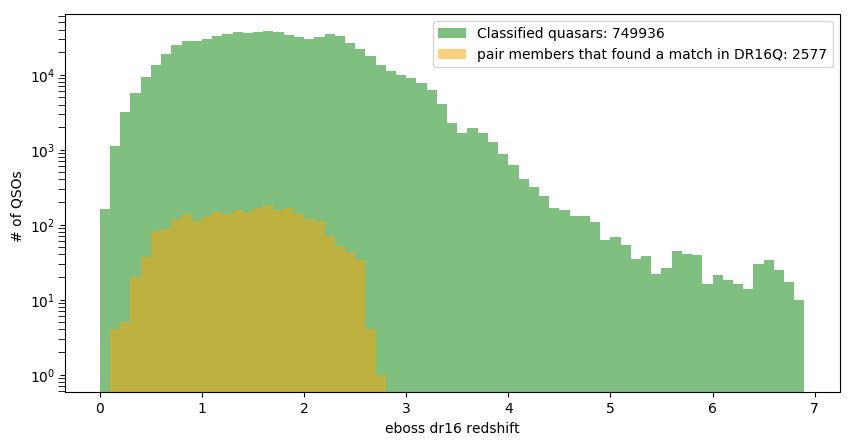

In [28]:
fig = plt.figure(figsize=(10, 5), dpi=100)

plt.hist(t['Z'], bins= np.arange(0,7,0.1),alpha=0.5,color='green')  # `density=False` would make counts
# plt.hist(dq['Z'][zind2], bins= np.arange(0,7,0.1),alpha=0.5,color='pink')  # `density=False` would make counts
plt.hist(dq['Z'][zind1], bins= np.arange(0,7,0.1),alpha=0.5,color='orange')  # `density=False` would make counts
plt.xlabel('eboss dr16 redshift')
plt.ylabel('# of QSOs ')
plt.yscale('log')
plt.legend(['Classified quasars: '+str(len(t)),'pair members that found a match in DR16Q: '+str(good_catch)])
plt.tick_params(which='minor', length=5)
# plt.text(0.,0.3e4,'Classified quasars with ZWARN_PCA==0 in DR16_v4: '+str(len(t)))
# plt.text(0.,0.1e4,'Matched UVX or LOWz pair candidates with DR16Q (both members have confirmed redshift): '+str(good_catch))
plt.savefig(path+'z_dist_pairs_dr16.png')


In [29]:
from astropy.cosmology import FlatLambdaCDM
from math import sqrt, pi

### theta x da(z) = Rp  ---> 2.9/3600. x dc/(1+z) = Rp 
z = np.arange(0.01,7,0.1)
cosmo = FlatLambdaCDM(H0=100, Om0=0.307, Tcmb0=2.725)
zdc = cosmo.comoving_distance(z).value

Rpmin = 2.9*(np.pi/180)*(1/3.6)*zdc/(1+z)  #in kpc/h
Rpmax = 62*(np.pi/180)*(1/3.6)*zdc/(1+z)

Rpmax7 = 7.7*(np.pi/180)*(1/3.6)*zdc/(1+z)

#### calculate Rp for the pairs Rp= angsep*dc/(1+z)
#### find actual pairs with |v|< 2000 km/s
z1 = dq['Z'][zind1]
z2 = dq['Z'][zind2]

q1imag = dq['MODELMAG'][zind1][:,3]
q2imag = dq['MODELMAG'][zind2][:,3]


q1gmag = dq['MODELMAG'][zind1][:,1]
q2gmag = dq['MODELMAG'][zind2][:,1]


v = 3e5 * (z1-z2)/(1+z1)

pairs = (abs(v) < 2000) & (q1gmag < 20.85) & (q2gmag < 20.85)

zpair1 = z1[pairs]
zpair2 = z2[pairs]


#print(np.min(zpair1),np.max(zpair1),np.sum(pairs))

dc_pair = cosmo.comoving_distance(zpair1).value
angsep = a['SEP'][goodind1][pairs] # shouldn't matter to use a['SEP'][goodind2]; identical
Rp_pair = angsep*(np.pi/180)*(1/3.6)* dc_pair/(1+zpair1)


### calculate Rp for pairs with one member to have found a redshift in DR16 and the other member is anything else
# halfgoodz = d['Z'][halfgoodzind]
# dc_hg = cosmo.comoving_distance(halfgoodz).value

# angsep_hg = a['SEP'][halfgood_ind] 
# Rp_hg = np.asarray(angsep_hg)*(np.pi/180)*(1/3.6)* dc_hg/(1+np.asarray(halfgoodz))


### calculate Rp for pairs with one member to have found a redshift in DR16 andthe other member is UNKNOWN [NA]
q_NA_z = dq['Z'][q_NA_zind]

dc_qNA = cosmo.comoving_distance(q_NA_z).value

angsep_qNA = a['SEP'][q_NA_flag] 
Rp_qNA = np.asarray(angsep_qNA)*(np.pi/180)*(1/3.6)* dc_qNA/(1+np.asarray(q_NA_z))

qgmag_qNA = dq['MODELMAG'][q_NA_zind][:,1] 
NAgmag_qNA = a['GMAG2'][q_NA_flag]
qNA_pairs = (qgmag_qNA < 20.85) & (dq['ZWARNING'][q_NA_zind]>0) & (q_NA_z <2.3) & (q_NA_z > 0.43)


##### Writing out the table of True quasar pairs with |v| < 2000 km/s

# t = Table()
# cc = Column(Rp_pair, name='Rp')
# t.add_column(cc,index=0)
# cc = Column(angsep, name='Sep_arcsec')
# t.add_column(cc,index=0)
# cc = Column(zpair1, name='Z1')
# t.add_column(cc,index=0)
# cc = Column(zpair2, name='Z2')
# t.add_column(cc,index=0)
# cc = Column(a['RA1'][goodind1][pairs], name='RA1')
# t.add_column(cc,index=0)
# cc = Column(a['DEC1'][goodind1][pairs], name='DEC1')
# t.add_column(cc,index=0)
# cc = Column(, name='EBOSS_TARGET_ID1') 
# t.add_column(cc,index=0)
# cc = Column(, name='i_MODELMAG1') 
# t.add_column(cc,index=0)

# t.add_column(cc,index=0)
# cc = Column(a['RA2'][goodind2][pairs], name='RA2')
# t.add_column(cc,index=0)
# cc = Column(a['DEC2'][goodind2][pairs], name='DEC2')
# t.add_column(cc,index=0)
# cc = Column(, name='EBOSS_TARGET_ID2') 
# t.add_column(cc,index=0)
# cc = Column(, name='i_MODELMAG2') 
# t.add_column(cc,index=0)
# cc = Column(abs(v[pairs]), name='velocity') # km/s
# t.add_column(cc,index=0)

# t.write(path+'eboss_true_QSObinaries.fits')




KeyError: "Key 'MODELMAG' does not exist."

In [ ]:
len(q_NA_flag), len(qgmag_qNA),len(qNA_pairs)

In [ ]:
#                                                                           
x= (qgmag_qNA < 20.85)  & (d['ZWARNING'][q_NA_zind]>0) & (q_NA_z <2.3) & (q_NA_z > 0.43)

print(len(d[q_NA_zind][x])) # 25 QSO-UNKNOWN pairs
print(len(d[zind1][pairs]))   ## 88 QSO-QSO confirmed eboss binaries

        
QQ = np.concatenate((d[zind1][pairs],d[zind2][pairs]),axis=0)

from astropy.table import Table, Column
import os

tt = Table(QQ)
col = np.concatenate((np.arange(len(d[zind1][pairs]))+1, np.arange(len(d[zind1][pairs]))+1), axis=0)
c = Column(col, name='PAIR_NUMBER')
tt.add_column(c, index=0)

path = '/uufs/chpc.utah.edu/common/home/astro/dawson/sarahE/KDE_eBOSS_pairmatch/'
outputname = path+'88_QQ_confirmed_pairs_ineBOSS_g20.85.fits'

if os.path.exists(outputname):
    os.remove(outputname)
tt.write(outputname)


ttt = Table(d[q_NA_zind][x])

outputname = path+'25_QSO-UNKNOWN_pairs_ineBOSS_g20.85.fits'

if os.path.exists(outputname):
    os.remove(outputname)
ttt.write(outputname)
print('Wrote the {} QSO-UNKNOWN pairs {}'.format())

In [ ]:
fig = plt.figure(figsize=(10, 5), dpi=100)
ax= fig.add_subplot(111)

### These Rp_47pairs are published in Eftekharzadeh et al 2017

Rp_47pairs = [34.6,36.1,26.1,35.3,26.5,35.6,35.3,25.6,22.9,26.1,23.4,
                         26.9,18.7,23.1,33.5,34.6,20.6,20.3,22.3,27.8,18.20,22.7,
                         27.5,20.5,24.8,31.3,34.0,33.6,19.5,30.4,22.0,20.2,
                         33.2,29.9,23.2,31.0,30.5,24.1,21.9,29.2,28.7,30.8,
                         17.7,28.8,22.6,20.8,21.8]

z_47_pairs = [1.838,1.545,0.778,1.961,2.195,1.911,1.677,1.744,1.956,
 1.666,2.173,1.164,2.062,1.795,1.445,1.596,1.529,2.180,
 1.686,1.597,1.721,1.799,1.534,0.573,1.324,1.245,0.912,
 2.261,1.506,1.151,1.153,1.584,1.376,1.905,0.863,1.809,
 1.249,1.535,1.494,0.641,0.870,2.018,0.770,1.587,1.961,2.080,1.597]




ofs=2
xlim = (0,400)#(np.min(Rpmin)-ofs,np.max(Rpmax)+40 )
ylim = (0.3,2.7)#(np.min(sq['DEC'])-ofs,np.max(sq['DEC'])+ofs )

#### the 12197 QSO-nonQSO
#py.plot(Rp_hg,np.asarray(halfgoodz),markersize = 2,marker='o',linestyle='',mfc='none',color='magenta')


#### the 
py.plot(Rp_qNA[qNA_pairs],np.asarray(q_NA_z)[qNA_pairs],markersize = 6,marker='o',linestyle='',mfc='none',color='magenta')


py.plot(Rpmin,z,linestyle='--',color='black',linewidth = 3)
py.plot(Rpmax,z,linestyle='--',color='black',linewidth = 3)
#py.plot(Rpmax7,z,linestyle='--',color='black',linewidth = 3)

py.plot(Rp_pair,zpair1,markersize = 6.8,marker='o',linestyle='',mfc='none',color='magenta')
py.plot(Rp_pair,zpair1,markersize = 6,marker='o',linestyle='',color='cyan')
py.plot(Rp_pair,zpair1,markersize = 6.8,marker='o',linestyle='',mfc='none',color='magenta')

py.plot(Rp_47pairs,z_47_pairs,markersize = 6.8,marker='o',linestyle='',mfc='none',color='maroon')
py.plot(Rp_47pairs,z_47_pairs,markersize = 6,marker='o',linestyle='',color='orange')
py.plot(Rp_47pairs,z_47_pairs,markersize = 6.8,marker='o',linestyle='',mfc='none',color='maroon')


ax.set_xlim((0,400))
ax.set_ylim((0.3,2.7))
ax.text(360,2.5,r'$\theta $'+' = 62"',fontsize=12)
ax.text(20,2.5,r'$\theta $'+' = 2.9"',fontsize=12)

#ax.set_title(plot_title)
ax.set_xlabel('Rp [kpc/h]',fontsize=15)
ax.set_ylabel('Z',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
ax.grid()

output_filename = 'Rp_z_eboss_kde_dr16_match.png'
plt.savefig(path+output_filename)

plt.show()


print('open pink circles are {} pairs with one member having had a redshift in DR16Q at {}<z<{}  '.format(np.sum(qNA_pairs),0.43,2.3))
print('filled orange circles are the {} pairs with both members to have found a redshift in DR14'.format(len(Rp_47pairs)))
print('filled cyan circles are {} pairs that both their members have found a redshift in DR16'.format(len(zpair1)))

In [ ]:
### magnitude distribution of confirmed pairs and the 

### 1116  QSO-NA pairs: two members, two sets of i-mags 2232 mags

###NOTE d  is the full spAll table
qimag_1116 = d['MODELMAG'][q_NA_zind][:,3]
NAimag_1116 = d['MODELMAG'][q_NA_flag][:,3] 

qgmag_1116 = d['MODELMAG'][q_NA_zind][:,1] 
NAgmag_1116 = d['MODELMAG'][q_NA_flag][:,1] 

###NOTE  t is te DR16Q catalog ; for 115 binary quasars 
q1imag = t['MODELMAG'][zind1][pairs][:,3]
q2imag = t['MODELMAG'][zind2][pairs][:,3]


q1gmag = t['MODELMAG'][zind1][pairs][:,1]
q2gmag = t['MODELMAG'][zind2][pairs][:,1]


angsep_qNA = a['SEP'][q_NA_ind]    # angular separation for 1116 QSO-NA pairs
angsep_qq = a['SEP'][goodind1][pairs]  # angular separation in arcsec for 115 QSO-QSO pairs


fig = plt.figure(figsize=(10, 5), dpi=100)
ax= fig.add_subplot(121)

plt.plot(angsep_qNA, qgmag_1116,marker='.',markersize=.9,color='green',linestyle='')
plt.plot(angsep_qq, q1gmag,marker='o',markersize=1.3,color='maroon',linestyle='',mfc='none')
plt.plot(angsep_qq, q2gmag,marker='o',markersize=1.3,color='magenta',linestyle='',mfc='none')



xlim = [0,62]
ylim = [17,23]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.text(360,2.5,r'$\theta $'+' = 62"',fontsize=12)
# ax.text(20,2.5,r'$\theta $'+' = 2.9"',fontsize=12)

#ax.set_title(plot_title)
ax.set_xlabel(r'$\theta [arcsec]$',fontsize=15)
ax.set_ylabel('g-mag',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')
ax.legend(['1116 pairs (1116x2 targets)','QQ pair member 1','QQ pair member 2'])



ax= fig.add_subplot(122)
plt.plot(angsep_qNA, qimag_1116,marker='.',markersize=.9,color='blue',linestyle='')
plt.plot(angsep_qq, q1imag,marker='o',markersize=1.3,color='maroon',linestyle='',mfc='none')
plt.plot(angsep_qq, q2imag,marker='o',markersize=1.3,color='magenta',linestyle='',mfc='none')


xlim = [0,62]
ylim = [17,23]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# ax.text(360,2.5,r'$\theta $'+' = 62"',fontsize=12)
# ax.text(20,2.5,r'$\theta $'+' = 2.9"',fontsize=12)

#ax.set_title(plot_title)
ax.set_xlabel(r'$\theta [arcsec]$',fontsize=15)
ax.set_ylabel('i-mag',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')

ax.legend(['1116 pairs (1116x2 targets)','QQ pair member 1','QQ pair member 2'])

fig.tight_layout() 



output_filename = 'gmag-imag_1116qNA_115qq.png'
plt.savefig(path+output_filename)


In [ ]:
### magnitude distribution of confirmed pairs and the 

### 1116  QSO-NA pairs: two members, two sets of i-mags 2232 mags

###NOTE d  is the full spAll table
qimag_1116 = d['MODELMAG'][q_NA_zind][:,3]
NAimag_1116 = d['MODELMAG'][q_NA_flag][:,3] 

qgmag_1116 = d['MODELMAG'][q_NA_zind][:,1] 
NAgmag_1116 = d['MODELMAG'][q_NA_flag][:,1] 


###NOTE  t is te DR16Q catalog ; for 115 binary quasars 
q1imag = t['MODELMAG'][zind1][pairs][:,3]
q2imag = t['MODELMAG'][zind2][pairs][:,3]


q1gmag = t['MODELMAG'][zind1][pairs][:,1]
q2gmag = t['MODELMAG'][zind2][pairs][:,1]


angsep_qNA = a['SEP'][q_NA_ind]    # angular separation for 1116 QSO-NA pairs
angsep_qq = a['SEP'][goodind1][pairs]  # angular separation in arcsec for 115 QSO-QSO pairs


fig = plt.figure(figsize=(10, 5), dpi=100)
ax= fig.add_subplot(121)

plt.plot(angsep_qNA, abs(qgmag_1116-NAgmag_1116),marker='.',markersize=.9,color='green',linestyle='')
plt.plot(angsep_qq, abs(q1gmag-q2gmag),marker='o',markersize=1.3,color='maroon',linestyle='',mfc='none')



# xlim = [0,62]
# ylim = [17,23]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.text(360,2.5,r'$\theta $'+' = 62"',fontsize=12)
# ax.text(20,2.5,r'$\theta $'+' = 2.9"',fontsize=12)

#ax.set_title(plot_title)
ax.set_xlabel(r'$\theta [arcsec]$',fontsize=15)
ax.set_ylabel(r'$|\Delta g|$',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')
ax.legend(['1116 pairs (1116x2 targets)','QQ pairs'])



ax= fig.add_subplot(122)
plt.plot(angsep_qNA, abs(qimag_1116-NAimag_1116),marker='.',markersize=.9,color='blue',linestyle='')
plt.plot(angsep_qq, abs(q1imag-q2imag),marker='o',markersize=1.3,color='maroon',linestyle='',mfc='none')
#plt.plot(angsep_qq, q2imag,marker='o',markersize=1.3,color='magenta',linestyle='',mfc='none')


#xlim = [0,62]
#ylim = [17,23]
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

# ax.text(360,2.5,r'$\theta $'+' = 62"',fontsize=12)
# ax.text(20,2.5,r'$\theta $'+' = 2.9"',fontsize=12)

#ax.set_title(plot_title)
ax.set_xlabel(r'$\theta [arcsec]$',fontsize=15)
ax.set_ylabel('$|\Delta i|$',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')

ax.legend(['1116 pairs (1116x2 targets)','QQ pairs'])

fig.tight_layout() 



output_filename = 'delta_igmag_1116qNA_115qq.png'
plt.savefig(path+output_filename)


In [ ]:
fig = plt.figure(figsize=(10, 5), dpi=100)

plt.hist(a['SEP'], bins= np.arange(0,64,2),alpha=0.5)  # `density=False` would make counts
plt.hist(matched_kde_eboss_pairs['SEP'], bins= np.arange(0,64,2),alpha=0.5,color='orange')  # `density=False` would make counts

plt.xlabel('Angular separation [arcsec] ')
plt.ylabel('# of QSO pair candidates (>2.9") in-DR6')
plt.yscale('log')
plt.tick_params(which='minor', length=5)
plt.text(0,2000,'Total number of  UVX or LOWz  pair candidates: '+str(len(a)))
plt.text(0,1500,'Total number of  matched UVX or LOWz  pair candidates with DR16Q : '+str(len(matched_kde_eboss_pairs)))

In [ ]:
fig = py.figure(figsize=(10, 5), dpi=100)
output_filename='115_ebosspairs.png'
ax= fig.add_subplot(111)

ofs=2
xlim = (360,0)#(np.min(sq['RA'])-ofs,np.max(sq['RA'])+ofs )
ylim = (-10,75)#(np.min(sq['DEC'])-ofs,np.max(sq['DEC'])+ofs )

ii = (d['Z'] > 0.8 ) & (d['Z'] <2.34) & (d['ZWARNING']==0)
py.plot(d['RA'][ii],d['DEC'][ii],marker='.',markersize=0.4,linestyle='',color='orange')

py.plot(a['RA1'][goodind1][pairs],a['DEC1'][goodind1][pairs],markersize = 6.8,marker='o',linestyle='',mfc='none',color='magenta')
py.plot(a['RA1'][goodind1][pairs],a['DEC1'][goodind1][pairs],markersize = 6,marker='o',linestyle='',color='cyan')
py.plot(a['RA1'][goodind1][pairs],a['DEC1'][goodind1][pairs],markersize = 6.8,marker='o',linestyle='',mfc='none',color='magenta')


ax.set_xlim(xlim)
ax.set_ylim(ylim)

#ax.set_title(plot_title)
ax.set_xlabel('R.A. [deg.]',fontsize=15)
ax.set_ylabel('Dec. [deg.]',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in') 
#ax.legend(['Green: QSO_NGC_v7_2: '+str(len(d)),' Blue: QSOs_NGC_v7_1: '+str(len(old))])
py.savefig(path+output_filename)
ax.grid()
plt.show()


In [ ]:
keys = ['SEP','RA1','DEC1','OBJID1','QSOTS1','LOWZTS1',
'MIDZTS1','HIGHZTS1','UVXTS1','QSOPROB1','STARPROB1',
'GMAG1','IMAG1','EBMV1','RA2','DEC2','OBJID2','QSOTS2',
'LOWZTS2','MIDZTS2 ','HIGHZTS2','UVXTS2','QSOPROB2',
'STARPROB2','IMAG2','GMAG2','EBMV2']

n=8

b=(a[goodind1][pairs])[n]
row = 'Rp[kpc/h]= '+str(np.round(Rp_pair[n],3))+' , '+'eboss_z1= '+str(np.round(zpair1[n],3))+' , '+'eboss_z2= '+str(np.round(zpair2[n],3))+' , '

for i,k in enumerate(keys):
    if b[i] < 1e6:
        row += keys[i]+'= '+str(np.round(b[i],3))+' , '
    else:
        row += keys[i]+'= '+str(int(b[i]))+' , '

print(row)    